<a href="https://colab.research.google.com/github/gugi200/final_project/blob/main/data_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#
#   Michael Gugala
#   02/12/2023
#   Image recognition
#   Master 4th year project
#   Univeristy of Bristol
#

!pip install torchmetrics
!pip install mlxtend>=0.19.0


import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

import torchvision
from torchvision import datasets#
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchmetrics
from torchvision.models import resnet50, ResNet50_Weights
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import Bunch

from PIL import Image

import requests
import random
import shutil
import zipfile
from pathlib import Path
import os

from timeit import default_timer as timer
from tqdm.auto import tqdm

# check imports
print(torch.__version__)
print(torchvision.__version__)

#agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 7.1 MB/s eta 0:00:00
2.1.0+cu121
0.16.0+cu121


'cpu'

# Download dataset from github

## download scaled dataset

The dataset that was scalled at the arduino level using an exponential mapping with coefficient alpha=20 (not sure if it was 10, 20, or 30 tho)

In [2]:
scalledDataPath = Path("og_scalled_data")

#  Create a dir
if scalledDataPath.is_dir():
    print('directory already exists')
else:
    scalledDataPath.mkdir(parents=True, exist_ok=True)

# download zipped data
    github_path = "https://github.com/gugi200/final_project/raw/main/dataset_pressure_sensor.zip"
    file = "dataset_pressure_sensor.zip"
with open(scalledDataPath / file, "wb") as f:
    request = requests.get(github_path)
    f.write(request.content)


# unzip the data
with zipfile.ZipFile(scalledDataPath / file, "r") as f:
    f.extractall(scalledDataPath)

## Download the raw dataset that was collected and sclalled manually at the post processing level

In [3]:
rawDatasetPath = Path("raw_data")

#  Create a dir
if rawDatasetPath.is_dir():
    print('directory already exists')
else:
    rawDatasetPath.mkdir(parents=True, exist_ok=True)

# download zipped data
    github_path = "https://github.com/gugi200/final_project/raw/main/data.zip"
    # file = "dataset_pressure_sensor.zip"
    file = 'data.zip'
with open(rawDatasetPath / file, "wb") as f:
    request = requests.get(github_path)
    f.write(request.content)


# unzip the data
with zipfile.ZipFile(rawDatasetPath / file, "r") as f:
    f.extractall(rawDatasetPath)

# Data extension and split

## arduino scalled data extention and split

In [4]:
customDirPath = scalledDataPath/"dataCollection1_sensor"
dirs = os.listdir(customDirPath)
from PIL import UnidentifiedImageError

#  Create a dir with processed data
extScaledTrain = Path("ext_scaled_train")
extScaledTest = Path("ext_scaled_test")

if extScaledTrain.is_dir():
    print('directory already exists')
else:
    extScaledTrain.mkdir(parents=True, exist_ok=True)
    for dir in dirs:
        path = extScaledTrain / dir
        path.mkdir(parents=True, exist_ok=True)

if extScaledTest.is_dir():
    print('directory already exists')
else:
    extScaledTest.mkdir(parents=True, exist_ok=True)
    for dir in dirs:
        path = extScaledTest / dir
        path.mkdir(parents=True, exist_ok=True)


fails = 0
index = 0
for dir in dirs:
    files = os.listdir(customDirPath / dir)
    random.shuffle(files)
    filesLength = len(files)
    trainRatio = 0.75
    trainLen = int(trainRatio*filesLength)
    for file in files[:trainLen]:
        try:
            img = Image.open(customDirPath / dir / file)
        except (NameError, UnidentifiedImageError):
            fails += 1
            pass
        imgNp = np.asarray(img)
        imgNp_T = np.transpose(imgNp)

        im = Image.fromarray(imgNp)
        im.save(f"{extScaledTrain}/{dir}/{dir}_{index}.jpg")

        im = Image.fromarray(imgNp_T)
        im.save(f"{extScaledTrain}/{dir}/{dir}_{index+1}.jpg")
        for i in range(3):
            imgNp = np.rot90(imgNp)
            imgNp_T = np.rot90(imgNp_T)

            im = Image.fromarray(imgNp)
            im.save(f"{extScaledTrain}/{dir}/{dir}_{(index) + (2*(i+1))}.jpg")

            im = Image.fromarray(imgNp_T)
            im.save(f"{extScaledTrain}/{dir}/{dir}_{(index) + (2*(i+1)) + 1}.jpg")

        index += 8

    for file in files[trainLen:]:
        try:
            img = Image.open(customDirPath / dir / file)
        except (NameError, UnidentifiedImageError):
            fails += 1
            pass
        imgNp = np.asarray(img)
        imgNp_T = np.transpose(imgNp)

        im = Image.fromarray(imgNp)
        im.save(f"{extScaledTest}/{dir}/{dir}_{index}.jpg")

        im = Image.fromarray(imgNp_T)
        im.save(f"{extScaledTest}/{dir}/{dir}_{index+1}.jpg")
        for i in range(3):
            imgNp = np.rot90(imgNp)
            imgNp_T = np.rot90(imgNp_T)

            im = Image.fromarray(imgNp)
            im.save(f"{extScaledTest}/{dir}/{dir}_{(index) + (2*(i+1))}.jpg")

            im = Image.fromarray(imgNp_T)
            im.save(f"{extScaledTest}/{dir}/{dir}_{(index) + (2*(i+1)) + 1}.jpg")

        index += 8

print('num of fails ', fails)
l = 0
for dir in dirs:
    l += len(os.listdir(extScaledTrain/dir))
    print(dir, len(os.listdir(extScaledTrain/dir)), len(os.listdir(customDirPath/dir)), len(os.listdir(customDirPath/dir))*8)
print(l)
lTest = 0
for dir in dirs:
    lTest += len(os.listdir(extScaledTest/dir))
    print(dir, len(os.listdir(extScaledTest/dir)), len(os.listdir(customDirPath/dir)), len(os.listdir(customDirPath/dir))*8)
print(lTest)
print(lTest+l)

num of fails  0
mug 6384 1065 8520
big_fizzy 6024 1004 8032
small_fizzy 6240 1040 8320
h_big_bottle 5864 978 7824
h_bottle 6096 1017 8136
hand 6024 1004 8032
36632
mug 2136 1065 8520
big_fizzy 2008 1004 8032
small_fizzy 2080 1040 8320
h_big_bottle 1960 978 7824
h_bottle 2040 1017 8136
hand 2008 1004 8032
12232
48864


## Raw dataseet extension and split
the data is extended and split into train and test dirs 3:1 split

In [5]:
customDirPath = rawDatasetPath/"data_sensor"
dirs = os.listdir(customDirPath)
from PIL import UnidentifiedImageError

#  Create a dir with processed data
extScaledTrain = Path("ext_raw_train")
extScaledTest = Path("ext_raw_test")

if extScaledTrain.is_dir():
    print('directory already exists')
else:
    extScaledTrain.mkdir(parents=True, exist_ok=True)
    for dir in dirs:
        path = extScaledTrain / dir
        path.mkdir(parents=True, exist_ok=True)

if extScaledTest.is_dir():
    print('directory already exists')
else:
    extScaledTest.mkdir(parents=True, exist_ok=True)
    for dir in dirs:
        path = extScaledTest / dir
        path.mkdir(parents=True, exist_ok=True)


fails = 0
index = 0
for dir in dirs:
    files = os.listdir(customDirPath / dir)
    random.shuffle(files)
    filesLength = len(files)
    trainRatio = 0.75
    trainLen = int(trainRatio*filesLength)
    for file in files[:trainLen]:
        try:
            img = Image.open(customDirPath / dir / file)
        except (NameError, UnidentifiedImageError):
            fails += 1
            pass
        imgNp = np.asarray(img)
        imgNp_T = np.transpose(imgNp)

        im = Image.fromarray(imgNp)
        im.save(f"{extScaledTrain}/{dir}/{dir}_{index}.jpg")

        im = Image.fromarray(imgNp_T)
        im.save(f"{extScaledTrain}/{dir}/{dir}_{index+1}.jpg")
        for i in range(3):
            imgNp = np.rot90(imgNp)
            imgNp_T = np.rot90(imgNp_T)

            im = Image.fromarray(imgNp)
            im.save(f"{extScaledTrain}/{dir}/{dir}_{(index) + (2*(i+1))}.jpg")

            im = Image.fromarray(imgNp_T)
            im.save(f"{extScaledTrain}/{dir}/{dir}_{(index) + (2*(i+1)) + 1}.jpg")

        index += 8

    for file in files[trainLen:]:
        try:
            img = Image.open(customDirPath / dir / file)
        except (NameError, UnidentifiedImageError):
            fails += 1
            pass
        imgNp = np.asarray(img)
        imgNp_T = np.transpose(imgNp)

        im = Image.fromarray(imgNp)
        im.save(f"{extScaledTest}/{dir}/{dir}_{index}.jpg")

        im = Image.fromarray(imgNp_T)
        im.save(f"{extScaledTest}/{dir}/{dir}_{index+1}.jpg")
        for i in range(3):
            imgNp = np.rot90(imgNp)
            imgNp_T = np.rot90(imgNp_T)

            im = Image.fromarray(imgNp)
            im.save(f"{extScaledTest}/{dir}/{dir}_{(index) + (2*(i+1))}.jpg")

            im = Image.fromarray(imgNp_T)
            im.save(f"{extScaledTest}/{dir}/{dir}_{(index) + (2*(i+1)) + 1}.jpg")

        index += 8

print('num of fails ', fails)
l = 0
for dir in dirs:
    l += len(os.listdir(extScaledTrain/dir))
    print(dir, len(os.listdir(extScaledTrain/dir)), len(os.listdir(customDirPath/dir)), len(os.listdir(customDirPath/dir))*8)
print(l)
lTest = 0
for dir in dirs:
    lTest += len(os.listdir(extScaledTest/dir))
    print(dir, len(os.listdir(extScaledTest/dir)), len(os.listdir(customDirPath/dir)), len(os.listdir(customDirPath/dir))*8)
print(lTest)
print(lTest+l)

num of fails  32
mug 6568 1095 8760
nothing 1832 306 2448
big_fizzy 6200 1034 8272
can 5984 998 7984
small_fizzy 5776 963 7704
h_big_bottle 6712 1119 8952
h_bottle 6288 1049 8392
hand 6000 1001 8008
45360
mug 2192 1095 8760
nothing 616 306 2448
big_fizzy 2072 1034 8272
can 2000 998 7984
small_fizzy 1928 963 7704
h_big_bottle 2240 1119 8952
h_bottle 2104 1049 8392
hand 2008 1001 8008
15160
60520


# Create a subset

## raw scalled dataset subset

In [6]:
# extCustomScaledDataset= scalledDataPath/"dataCollection1_sensor"
customRawDataset = rawDatasetPath/"data_sensor"
TRAIN_LENGTH_PER_CLASS = 500
TEST_LENGTH_PER_CLASS = 125
dirs = os.listdir(customRawDataset)


#  Create a dir for train and test data
shortRawTrain = Path("short_rawTrain")
shortRawTest = Path("short_rawTest")
if shortRawTrain.is_dir():
    print('directory already exists')
else:
    shortRawTrain.mkdir(parents=True, exist_ok=True)
    shortRawTest.mkdir(parents=True, exist_ok=True)
    for dir in dirs:
        path = shortRawTrain / dir
        path.mkdir(parents=True, exist_ok=True)
    for dir in dirs:
        path = shortRawTest / dir
        path.mkdir(parents=True, exist_ok=True)

for dir in dirs:
    files = os.listdir(customRawDataset / dir)
    random.shuffle(files)

    train_set = files[:TRAIN_LENGTH_PER_CLASS]
    test_set = files[TRAIN_LENGTH_PER_CLASS:TRAIN_LENGTH_PER_CLASS+TEST_LENGTH_PER_CLASS]

    for data in train_set:
        shutil.copy(customRawDataset / dir / data, shortRawTrain / dir / data)

    for data in test_set:
        shutil.copy(customRawDataset / dir / data, shortRawTest / dir / data)

l = 0
for dir in dirs:
    l += len(os.listdir(shortRawTrain/dir))
    print(dir, len(os.listdir(shortRawTrain/dir)))
print(l)

lTest = 0
for dir in dirs:
    lTest += len(os.listdir(shortRawTest/dir))
    print(dir, len(os.listdir(shortRawTest/dir)))
print(lTest)
print(l+lTest)


mug 500
nothing 306
big_fizzy 500
can 500
small_fizzy 500
h_big_bottle 500
h_bottle 500
hand 500
3806
mug 125
nothing 0
big_fizzy 125
can 125
small_fizzy 125
h_big_bottle 125
h_bottle 125
hand 125
875
4681


# Library

In [7]:
from pickle import NONE
# create data set from a custom data
def create_dataset(path, batchsize, mean=None, std=None):
    '''
    input:
    path - path to the folder with the data
           eg for train - "data/FashionMNIST/train"
    batchsize - eg 32
    mean (optional)- for normalization eg. [0.25, 0.25, 0.25]
    std (optional)- for nortmalization eg [0.1, 0.1, 0.1]

    returns:
    dataloader with image size of 224
    class_names
    '''
    if mean:
        preprocess = transforms.Compose([

            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    else:
        preprocess = transforms.Compose([

            transforms.Resize(size=(224, 224)),
            transforms.ToTensor()
        ])


    data = datasets.ImageFolder(root=Path(path),
                                    transform=preprocess, # tranform for the data
                                    target_transform=None) # transform for label
    dataloader = DataLoader(dataset=data,
                                batch_size=batchsize,
                                shuffle=True) #  shuffling to remove order
    class_names = data.classes
    return dataloader, class_names, data.targets

# visdualize 9 random images in a batch
def visualise_data(dataloader, class_names, batchsize):
    '''
    input dataloader
    class names

    displays 9 random images in a batch and their labels
    '''
    train_features_batch, train_labels_batch = next(iter(dataloader))
    print("length of data: ", len(train_features_batch), 'length of labels: ', len(train_labels_batch))
    # display random datapoints
    fig = plt.figure(figsize=(9, 9))
    rows, cols  = 3, 3
    for pic in range(1, 1+rows*cols):
        rand_int = np.random.randint(0, batchsize)
        img = train_features_batch[rand_int]
        img_RGB = img.permute([1, 2, 0]).numpy()
        fig.add_subplot(rows, cols, pic)
        plt.imshow(img_RGB.squeeze())
        plt.axis(False)
        plt.title(class_names[train_labels_batch[rand_int]])


# create optimizer
def create_optiimizer(model, optimizer, lr):
    '''
    inputs:
    model - CNN network
    optimizer - "adam" or "sgd"
    lr - learning rate eg. 0.01

    '''
    if optimizer=='adam':
        optimizer = torch.optim.Adam(model.parameters(),
                                     lr=lr
                                     )
    elif optimizer=='sgd':
        optimizer = torch.optim.SGD(model.parameters(),
                                     lr=lr,
                                    momentum=0.9
                                     )

    return optimizer


def get_lossFn():
    '''
        returns CrossEntropyLoss function
    '''

    return nn.CrossEntropyLoss()

# create train step
def train_step(model, metric, loss_fn, optimizer,
               data_loader, device, debug=False, wnb=True):
    '''
    model - CNN network
    metric - metric to calculate accuracy
    loss_fn - loss function
    optimizer - optimizer to be applied
    data_loader - dataloader
    device - decide for the model to train
    debug (optional)- if True prints average loss and metric of the batch

    returns
    train_loss - average loss of the batch
    train_acc - average metric score of the batch

    The function saves the metric score and loss of each iteration in WandB

    '''
    train_loss, train_acc = 0, 0

    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # put data on the device
        X, y = X.to(device), y.to(device)

        #forward pass, return raw logits
        y_pred = model(X)

        #loss
        loss = loss_fn(y_pred, y)
        #accuracy
        acc = metric(y, torch.argmax(y_pred, dim=1))

        train_loss += loss # accumulate train loss
        train_acc += acc # accumulate train accuracy

        # zero grad
        optimizer.zero_grad()

        # loss bacward
        loss.backward()

        #optimizer step
        optimizer.step()

        # log in wandb
        if wnb:
            wandb.log({"loss": loss,
                       'accuracy': acc})

    # device total loss and accuracy by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if debug:
        print(f'Train loss: {train_loss:.4f}, Train acc: {train_acc*100:0.4f}%')

    return train_loss, train_acc


# create test step
def test_step(model, metric, loss_fn, data_loader, device, debug=False, wnb=True):
    '''
    model - CNN network
    metric - metric to calculate accuracy
    loss_fn - loss function
    data_loader - dataloader
    device - decide for the model to train
    debug (optional)- if True prints average loss and metric of the batch

    returns
    test_loss - average loss of the batch
    test_acc - average metric score of the batch

    The function saves the metric score and loss of each iteration in WandB

    '''
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            #1 forward pass
            test_pred = model(X_test)

            # calculate loss
            loss = loss_fn(test_pred, y_test)
            test_loss += loss

            #accuracy
            acc = metric(y_test, test_pred.argmax(dim=1))
            test_acc += acc

            if wnb:
                wandb.log({"test loss": loss,
                           'test accuracy': acc})

        # Calculate the test loss average batch
        test_loss /= len(data_loader)

        # acc per bactch
        test_acc /= len(data_loader)

        # Print out what's happening
        if debug:
            print(f'Test loss: {test_loss:.4f}  |  Test acc: {test_acc*100:.4f}%')

        return test_loss, test_acc

# create evaluation loop
def eval_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
               device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            #accumulate the loss and acc
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # ave loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works if a model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc.item()*100}




def visualize_preds(model, dataloader, class_names, batchsize):
    plt.figure(figsize=(9, 9))
    nrows = 3
    ncols = 3
    model = model.cpu()

    dataL_len = len(dataloader)
    data = iter(dataloader)
    for i in range(3):
        model.eval()
        with torch.inference_mode():

            X, y = next(data)
            X, y = X.cpu(), y.cpu()
            for j in range(3):
                randint = np.random.randint(0, batchsize)
                X_sample, y_sample = X[randint], y[randint]
                pred_logit = model(X_sample.unsqueeze(dim=0))

                pred_prob = pred_logit.argmax(dim=1)


                plt.subplot(nrows, ncols, (3*i)+j+1);
                plt.imshow(X_sample.squeeze().permute([1, 2, 0]), cmap='gray');

                #find pred_label in text form
                pred_label = class_names[pred_prob];

                # find truth label
                truth_label = class_names[y_sample];

                title_text = f'Pred: {pred_label}  \n  Truth: {truth_label}'

                if pred_label==truth_label:
                    plt.title(title_text, fontsize=10, c='g');
                else:
                    plt.title(title_text, fontsize=10, c='r');
                plt.axis(False)
                plt.tight_layout()



def plot_decision_matrix(class_names, y_pred_tensor, targets):
    # setup confusion matrix
    confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')

    confmat_tensor = confmat(preds=y_pred_tensor,
                            target=targets)

    # plot consufionmatrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=(10, 7)
    )

def make_predictions(model, data, device):
    model.eval()
    data = data.to(device)
    model = model.to(device)
    with torch.inference_mode():
        y_preds = model(data)
    return y_preds.cpu()

def make_predictions_dataloader(model, dataloader, device):
    preds = []
    target = []
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            batch_pred = model(X_test)
            batch_pred = batch_pred.cpu()
            y_test = y_test.cpu()
            preds.append(np.array(batch_pred.argmax(dim=1)))
            target.append(y_test)
    pred = np.array(preds)
    target = np.array(target)
    return np.concatenate(pred), np.concatenate(target)




def dataloader_to_numpy(dataloader):
    for i, (data, target) in enumerate(dataloader):
        if i==0:
            data_numpy = data.numpy()
            target_numpy = target.numpy()
        else:
            data_numpy = np.append(data_numpy, data.numpy(), axis=0)
            target_numpy = np.append(target_numpy, target.numpy(), axis=0)
    return data_numpy, target_numpy


def get_datalodaer(train_data_path, test_data_path, batchsize):

    train_dataloader, class_names, _ = create_dataset(
                                        path=train_data_path,
                                        batchsize=batchsize,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]
                                    )
    test_dataloader, _, _ = create_dataset(
                                path=test_data_path,
                                batchsize=batchsize,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]
                                    )
    return train_dataloader, test_dataloader, class_names


def train_test_loop(config, model, train_dataloader, test_dataloader,
                    class_names):
    loss_fn = get_lossFn()
    optimizer = create_optiimizer(model=model,
                                    optimizer=config.optimizer,
                                    lr=config.learning_rate
    )
    metric = torchmetrics.classification.Accuracy(
        task="multiclass",
        num_classes=len(class_names)
    ).to(device)
    train_time_start = timer()
    for epoch in range(config.epochs):
        ave_batch_loss, ave_batch_metric = train_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            debug=True
        )
        ve_batch_loss, ave_batch_metric = test_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            data_loader=test_dataloader,
            device=device,
            debug=True
        )
        wandb.log({"average train batch loss": ave_batch_loss,
                    "average train batch metric": ave_batch_metric,
                    "average test batch loss": ave_batch_loss,
                    "average test batch metric": ave_batch_metric,
                    "epoch": epoch
                    })
    train_time_end = timer()
    wandb.log({"train time": train_time_end - train_time_start})



# Data transformations
on extScaledTrain
and extRawTrain

In [8]:


def train_model_restent50(train_dataloader, test_dataloader, lr, optimizer, batchsize, epochs, class_names, model):
    print(device)

    model = model.to(device)
    loss_fn = get_lossFn()
    optimizer = create_optiimizer(model=model,
                                    optimizer=optimizer,
                                    lr=lr
    )


    metric = torchmetrics.classification.Accuracy(
        task="multiclass",
        num_classes=len(class_names)
    ).to(device)
    train_time_start = timer()
    for epoch in tqdm(range(epochs)):
        ave_batch_loss, ave_batch_metric = train_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            wnb=False,
            debug=True
        )
        ve_batch_loss, ave_batch_metric = test_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            data_loader=test_dataloader,
            device=device,
            wnb=False,
            debug=True
        )

    train_time_end = timer()

    return model


def modelRun(precosesing, verbose=False):
    train_dataset = ImageFolder(root=shortRawTrain, transform=precosesing)
    train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=16,
                                shuffle=True)
    test_dataset = ImageFolder(root=shortRawTest, transform=precosesing)
    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=16,
                                shuffle=True)
    class_names = train_dataset.classes

    # get model
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(2048, len(class_names))
    newModel = train_model_restent50(train_dataloader=train_dataloader,
                                 test_dataloader=test_dataloader,
                                 lr=0.001,
                                 optimizer='adam',
                                 batchsize=16,
                                 epochs=5,
                                 class_names=class_names,
                                 model=model).cpu()

    if verbose:
        data_test_numpy, target_test_numpy = dataloader_to_numpy(test_dataloader)

        y_test_preds_tensor = make_predictions(model=newModel,
                                data=torch.tensor(data_test_numpy),
                                device=device
                                )

        plot_decision_matrix(class_names=class_names,
                            y_pred_tensor=y_test_preds_tensor,
                            targets=torch.tensor(target_test_numpy))


def produceExpMapFuncs(coeffs):
    funcs = []
    for coeff in coeffs:
        def expMapping(data):
            data = np.asarray(data)
            data = np.where(data==0, 1, data)
            mapped = np.exp( -( coeff/(data) ) )*255
            mapped = mapped.astype(np.uint8)
            return Image.fromarray(mapped)
        funcs.append(expMapping)

    return funcs
def produceSoftMapFuncs(coeffs):
    funcs = []
    for (lower, upper) in coeffs:
        def expMapping(data):
            data = np.asarray(data)
            th = np.where(data>upper, 255, data)
            th = np.where(th<lower, 0, th).astype(np.uint8)
            return Image.fromarray(th)
        funcs.append(expMapping)

    return funcs

coeffsExp = [6, 7, 8, 9]
expFuncs = produceExpMapFuncs([5, 6, 7, 8, 9, 10])
softCoeffs = [(10, 90), (10, 110), (10, 130),

              (30, 90), (30, 110), (30, 130),
              (40, 90), (40, 110), (40, 130),]
softFuncs = produceSoftMapFuncs(softCoeffs)



for funcExp, coeffExp  in zip(expFuncs, coeffsExp):
    for funcSoft, coeffSoft in zip(softFuncs, softCoeffs):
        print('The current alpha=', coeffExp)
        print('The current soft=', coeffSoft)
        preprocess = transforms.Compose([
            transforms.Lambda(funcExp),
            transforms.Lambda(funcSoft),
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
        ])
        modelRun(preprocess)


The current alpha= 6
The current soft= (10, 90)


FileNotFoundError: Found no valid file for the classes nothing. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

# dataset cleaning

In [25]:
import os
from PIL import Image
from PIL import UnidentifiedImageError

for folder_path in [shortRawTrain, shortRawTest, Path('raw_data/data_sensor')]:
    extensions = []
    for fldr in os.listdir(folder_path):
        sub_folder_path = os.path.join(folder_path, fldr)
        for filee in os.listdir(sub_folder_path):
            file_path = os.path.join(sub_folder_path, filee)
            try:
                im = Image.open(file_path)
            except UnidentifiedImageError:
                print(file_path)
                os.remove(file_path)


# display mapping schemes

## display raw data

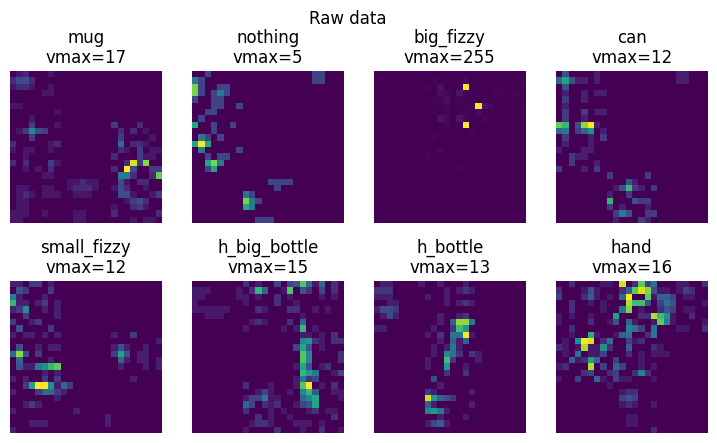

In [26]:
def displayEachClass(path, title, transfroms=None):
    dirs = os.listdir(path)
    plt.figure(figsize=(9, 5))
    plt.suptitle(title)
    subplot_i = 1
    for _dir in dirs:
        file = random.choice(os.listdir(path/_dir))
        img = Image.open(path/_dir/file)
        img_np = np.asarray(img)
        if transfroms:
            for transfrom in transfroms:
                img_np = transfrom(img_np)
        ax = plt.subplot(2, 4, subplot_i)
        ax.set_title(_dir + '\nvmax=' + str(np.max(img_np).astype(np.uint8)))
        ax.imshow(img_np, vmax = np.max(img_np))
        ax.axis(False)
        subplot_i += 1



rawDataPath = Path("raw_data/data_sensor")
displayEachClass(rawDataPath, 'Raw data')


## a few example of each class

raw_data/data_sensor/mug
['sensor_4210.jpg', 'sensor_4554.jpg', 'sensor_4465.jpg', 'sensor_4291.jpg', 'sensor_5125.jpg', 'sensor_4261.jpg', 'sensor_4582.jpg', 'sensor_5168.jpg']
raw_data/data_sensor/nothing
['sensor_4440.jpg', 'sensor_6439.jpg', 'sensor_3567.jpg', 'sensor_7132.jpg', 'sensor_7357.jpg', 'sensor_2408.jpg', 'sensor_5612.jpg', 'sensor_1671.jpg']
raw_data/data_sensor/big_fizzy
['sensor_4056.jpg', 'sensor_3509.jpg', 'sensor_6706.jpg', 'sensor_6790.jpg', 'sensor_6463.jpg', 'sensor_6591.jpg', 'sensor_6451.jpg', 'sensor_6392.jpg']
raw_data/data_sensor/can
['sensor_7097.jpg', 'sensor_3093.jpg', 'sensor_2971.jpg', 'sensor_7104.jpg', 'sensor_3180.jpg', 'sensor_4924.jpg', 'sensor_2861.jpg', 'sensor_5574.jpg']
raw_data/data_sensor/small_fizzy
['sensor_6280.jpg', 'sensor_6113.jpg', 'sensor_6360.jpg', 'sensor_6929.jpg', 'sensor_6103.jpg', 'sensor_7317.jpg', 'sensor_6900.jpg', 'sensor_6191.jpg']
raw_data/data_sensor/h_big_bottle
['sensor_1841.jpg', 'sensor_2065.jpg', 'sensor_1791.jpg', 

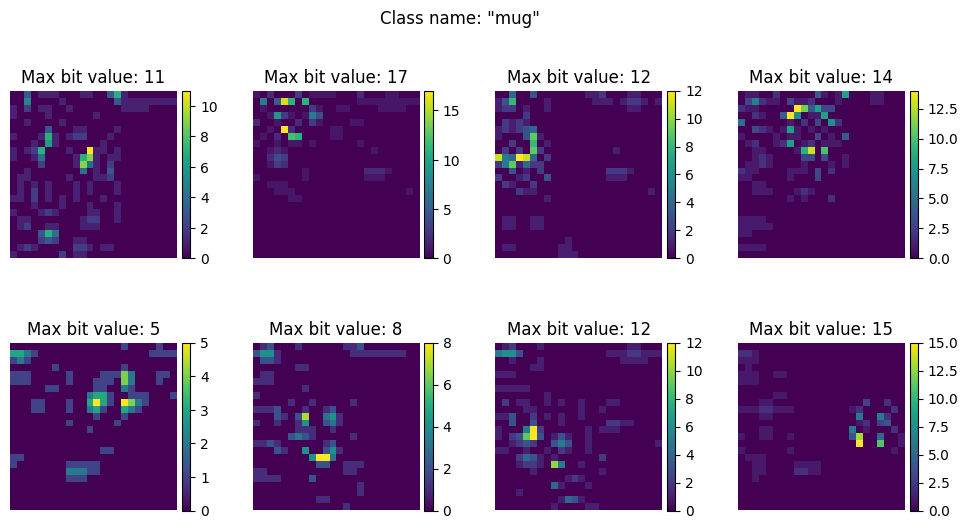

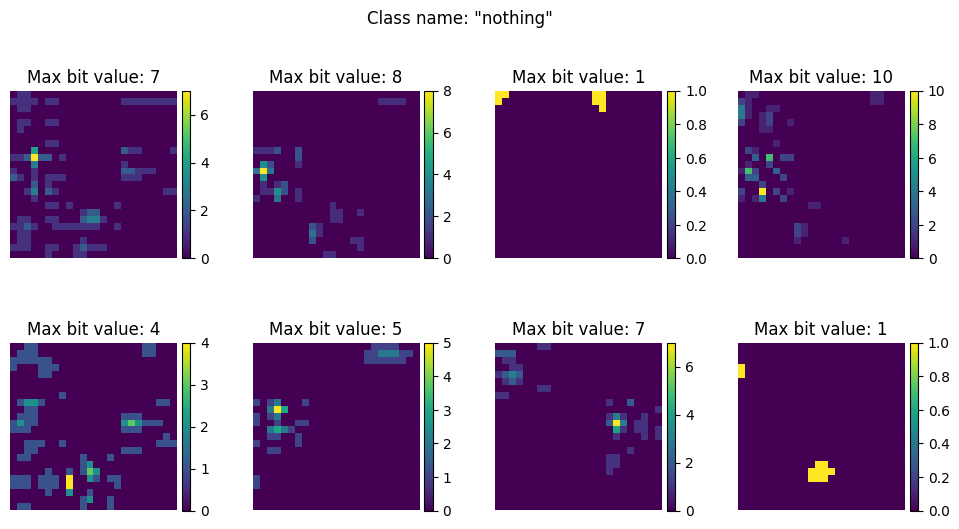

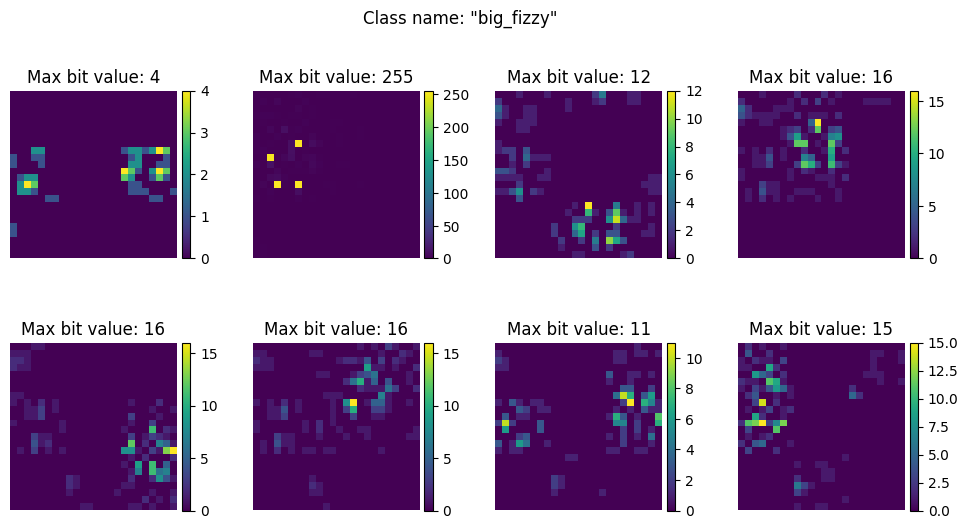

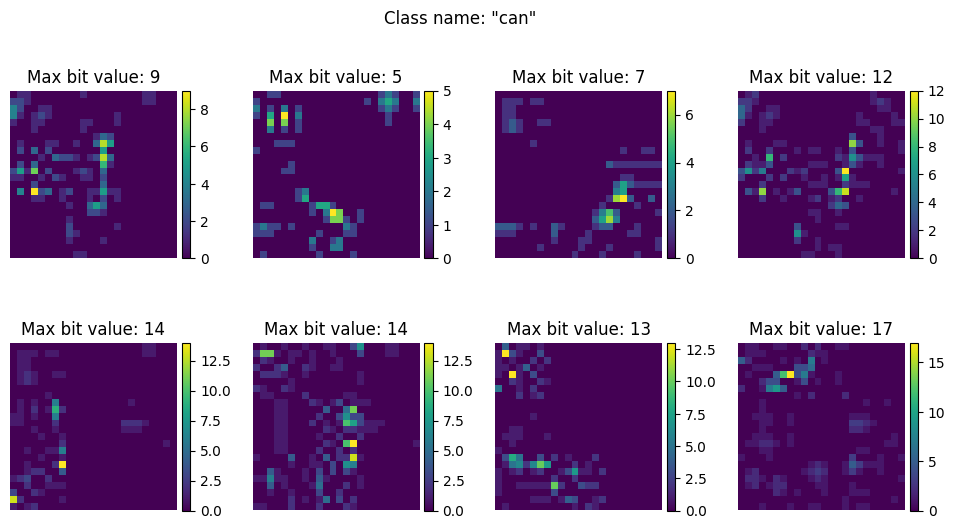

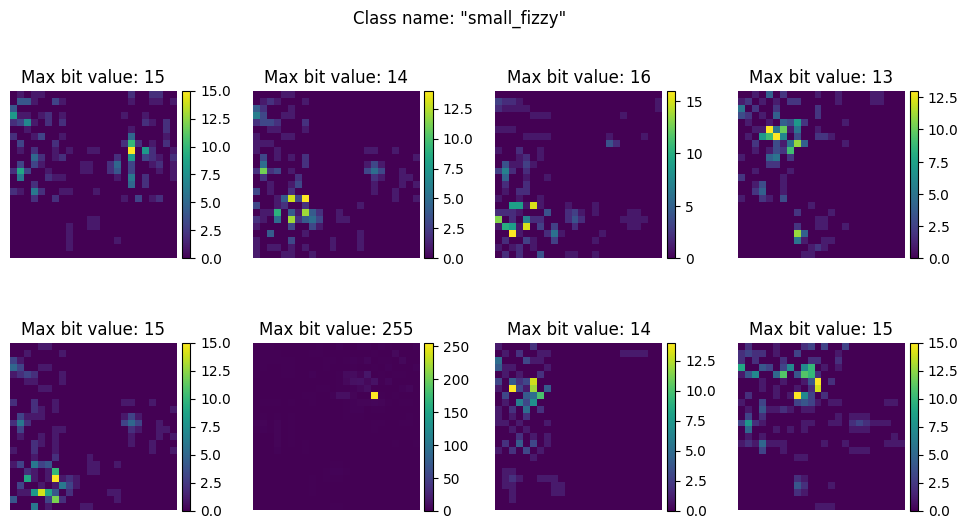

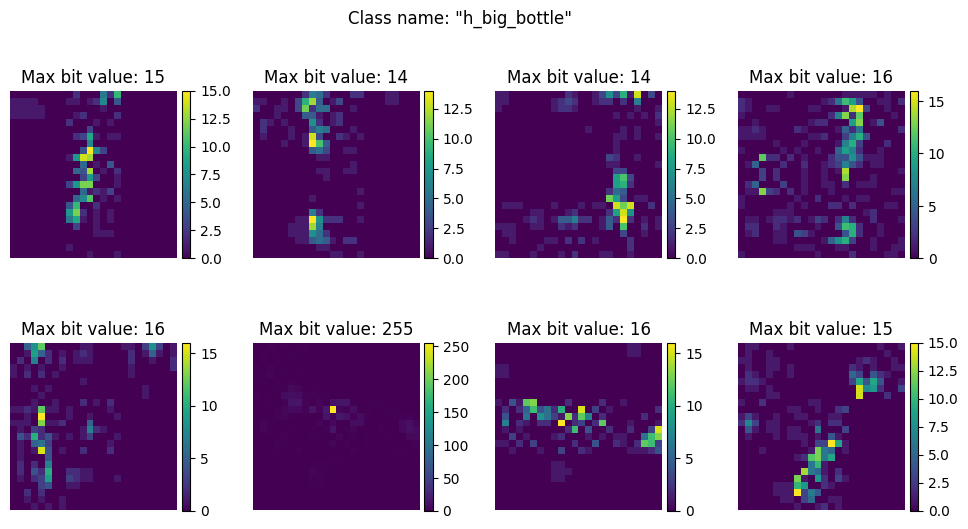

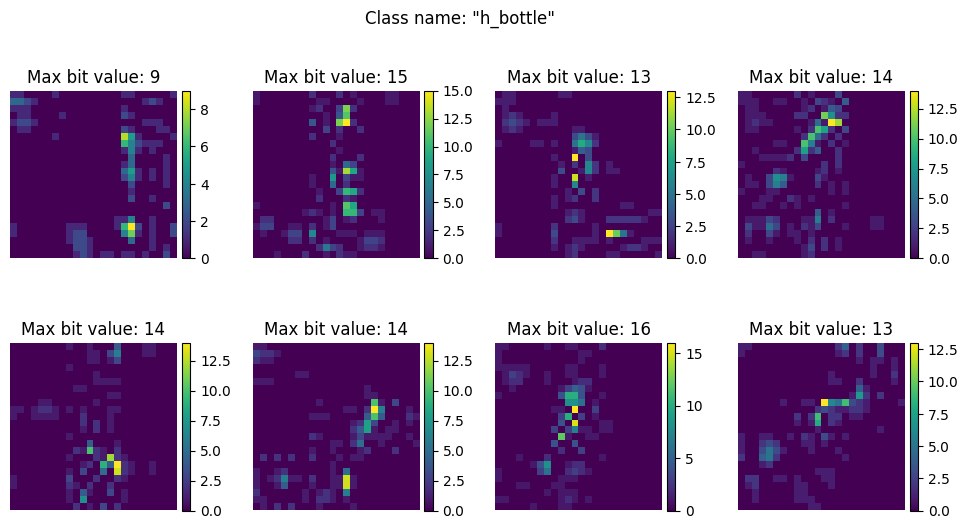

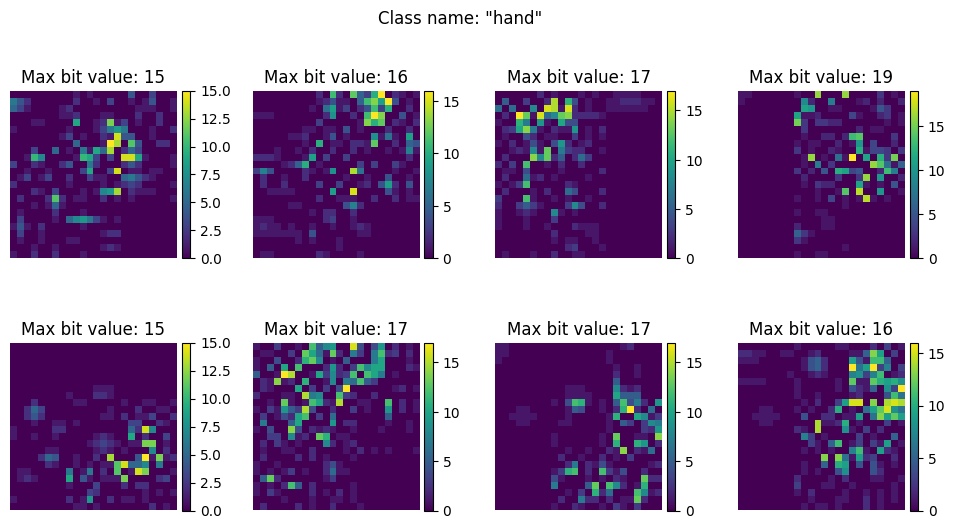

In [107]:
import matplotlib as mpl
def displayClass(path, title, ncols=5, nrows=2, transfroms=None):

    plt.figure(figsize=(12, 6))
    plt.suptitle(title)
    subplot_i = 1
    V_max_tot = 0
    random.seed(22)
    files = file = random.choices(os.listdir(path), k=ncols*nrows)

    print(path)
    print(files)
    imgs = [np.asarray(Image.open(path/file)) for file in files]
    # v_maxs = [np.max(img) for img in imgs]
    # v_max_tot = np.max(np.asarray(v_maxs))
    for img in imgs:
        img_np = np.asarray(img)
        if transfroms:
            for transfrom in transfroms:
                img_np = transfrom(img_np)
        vmax = np.max(img_np).astype(np.uint8)
        ax = plt.subplot(nrows, ncols, subplot_i)
        ax.set_title('Max bit value: ' + str(vmax))
        ax.imshow(img_np, vmax = vmax)
        ax.axis(False)
        subplot_i += 1

        cmap = plt.cm.Greys
        norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
        plt.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=ax, pad=0.025, shrink=0.8)



rawDataPath = Path("raw_data/data_sensor")
dirs = os.listdir(rawDataPath)
for dir in dirs:
    displayClass(rawDataPath/dir, f'Class name: "{dir}"\n', 4, 2)

## display lower boundary of soft threshold

raw_data/data_sensor/mug
['sensor_3844.jpg', 'sensor_5965.jpg', 'sensor_5482.jpg', 'sensor_2457.jpg', 'sensor_2416.jpg', 'sensor_7512.jpg', 'sensor_2607.jpg', 'sensor_3856.jpg', 'sensor_7373.jpg', 'sensor_2590.jpg', 'sensor_7384.jpg', 'sensor_2667.jpg', 'sensor_6031.jpg', 'sensor_5413.jpg', 'sensor_5460.jpg', 'sensor_2595.jpg', 'sensor_2636.jpg', 'sensor_3423.jpg', 'sensor_2569.jpg', 'sensor_5411.jpg', 'sensor_2552.jpg', 'sensor_2604.jpg', 'sensor_7527.jpg', 'sensor_5948.jpg', 'sensor_7432.jpg', 'sensor_3491.jpg', 'sensor_3403.jpg', 'sensor_4089.jpg', 'sensor_2533.jpg', 'sensor_2659.jpg', 'sensor_5388.jpg', 'sensor_2610.jpg', 'sensor_2473.jpg', 'sensor_7489.jpg', 'sensor_5489.jpg', 'sensor_2559.jpg', 'sensor_2476.jpg', 'sensor_1155.jpg', 'sensor_3842.jpg', 'sensor_7547.jpg', 'sensor_7423.jpg', 'sensor_2462.jpg', 'sensor_5434.jpg', 'sensor_2498.jpg', 'sensor_1149.jpg', 'sensor_7523.jpg', 'sensor_2516.jpg', 'sensor_3466.jpg', 'sensor_1121.jpg', 'sensor_2468.jpg', 'sensor_3432.jpg', 'sens

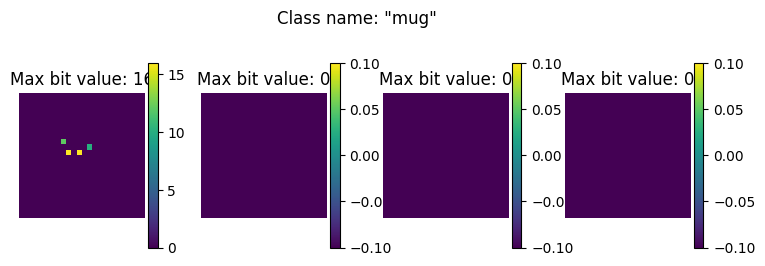

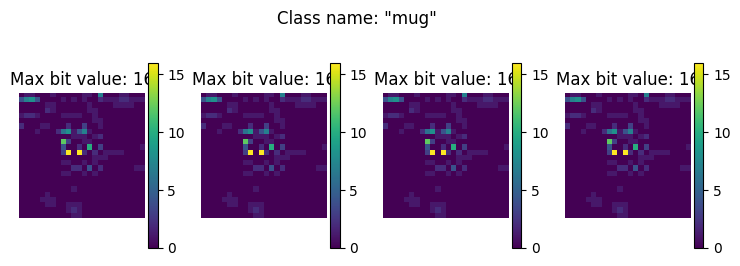

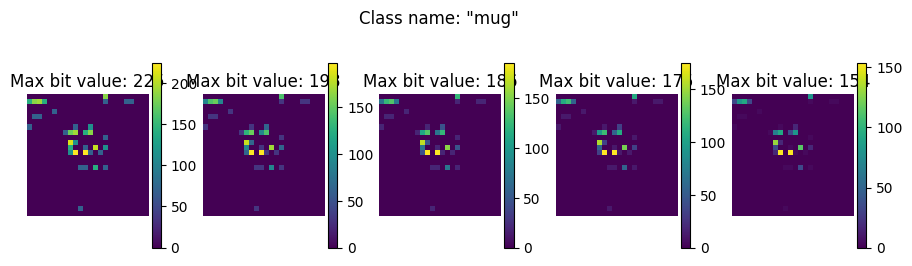

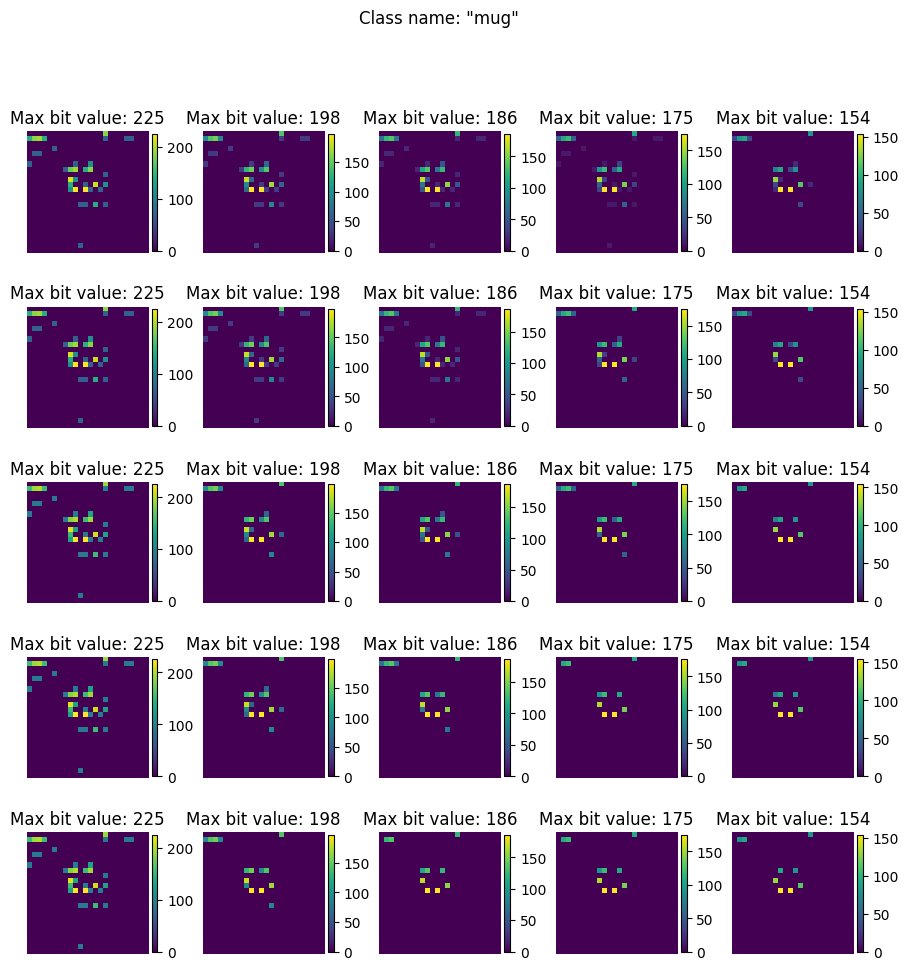

In [123]:
def displayClassTransform(path, title, ncols=5, nrows=2, transfroms=None):

    plt.figure(figsize=((ncols*2)+1, (nrows*2)+1))
    plt.suptitle(title)
    subplot_i = 1
    V_max_tot = 0
    random.seed(22)
    file= random.choice(os.listdir(path))
    print(path)
    print(files)
    img = Image.open(path/file)
    # v_maxs = [np.max(img) for img in imgs]
    # v_max_tot = np.max(np.asarray(v_maxs))
    for transformStack in transfroms:
        img_np = np.asarray(img)

        if transformStack:
            for transfrom in transformStack:
                img_np = transfrom(img_np)

        vmax = np.max(img_np).astype(np.uint8)
        ax = plt.subplot(nrows, ncols, subplot_i)
        ax.set_title('Max bit value: ' + str(vmax))
        ax.imshow(img_np, vmax = vmax)
        ax.axis(False)
        subplot_i += 1

        cmap = plt.cm.Greys
        norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
        plt.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=ax, pad=0.025, shrink=0.8)


def softThreshold(lower, upper):
    def func(data):
        data = np.asarray(data)
        th = np.where(data>upper, 255, data)
        th = np.where(th<lower, 0, th).astype(np.uint8)
        return Image.fromarray(th)
    return func

def expMapping(alpha):
    def func(data):
            data = np.asarray(data)
            data = np.where(data==0, 1, data)
            mapped = np.exp( -( alpha/(data) ) )*255
            mapped = mapped.astype(np.uint8)
            return Image.fromarray(mapped)
    return func

softLowerT = [[softThreshold(10, 255)], [softThreshold(20, 255)],[softThreshold(30, 255)],[softThreshold(40, 255)]]
ExpT = [[expMapping(2)], [expMapping(4)], [expMapping(5)], [expMapping(6)], [expMapping(8)]]
softExpT = [[expMapping(2), softThreshold(10, 255)], [expMapping(4), softThreshold(10, 255)], [expMapping(5), softThreshold(10, 255)], [expMapping(6), softThreshold(10, 255)], [expMapping(8), softThreshold(10, 255)],
        [expMapping(2), softThreshold(20, 255)], [expMapping(4), softThreshold(20, 255)], [expMapping(5), softThreshold(20, 255)], [expMapping(6), softThreshold(20, 255)], [expMapping(8), softThreshold(20, 255)],
        [expMapping(2), softThreshold(40, 255)], [expMapping(4), softThreshold(40, 255)], [expMapping(5), softThreshold(40, 255)], [expMapping(6), softThreshold(40, 255)], [expMapping(8), softThreshold(40, 255)],
        [expMapping(2), softThreshold(60, 255)], [expMapping(4), softThreshold(60, 255)], [expMapping(5), softThreshold(60, 255)], [expMapping(6), softThreshold(60, 255)], [expMapping(8), softThreshold(60, 255)],
        [expMapping(2), softThreshold(80, 255)], [expMapping(4), softThreshold(80, 255)], [expMapping(5), softThreshold(80, 255)], [expMapping(6), softThreshold(80, 255)], [expMapping(8), softThreshold(80, 255)]]



rawDataPath = Path("raw_data/data_sensor")
dirs = os.listdir(rawDataPath)


displayClassTransform(rawDataPath/dirs[0], f'Class name: "{dirs[0]}"\n', 4, 1, softLowerT)
displayClassTransform(rawDataPath/dirs[0], f'Class name: "{dirs[0]}"\n', 4, 1, [0, 0, 0, 0])
displayClassTransform(rawDataPath/dirs[0], f'Class name: "{dirs[0]}"\n', 5, 1, ExpT)
displayClassTransform(rawDataPath/dirs[0], f'Class name: "{dirs[0]}"\n', 5, 5, softExpT)



## display exponential mapping